In [1]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt

Load and clean the dataset

In [2]:
df = pd.read_csv('WHO/ledata.csv')
df = df.dropna()

del df['Country']
del df['Year']
del df['Status']

y = df['Life expectancy '].to_numpy()

del df['Life expectancy ']

A = df.to_numpy()

n_train = 1349

A_train = A[:1349:]
y_train = y[:1349]

A_test = A[1349::]
y_test = y[1349:]

print(A_train.shape)

## data normalization 

mA = A_train.mean(axis=0)
sA = A_train.std(axis=0)


A_train = (A_train-mA)/sA
A_test = (A_test-mA)/sA

m = y_train.mean()
y_train = y_train-m
y_test = y_test-m

(1349, 18)


In [21]:
### Stochastic gradient descent

def SGD(A,y,eps=1e-5,lr = None,verbose=0,itemax=17000,batch_size=1):
    X = np.zeros(A.shape[1])
    grad = np.array([1000]*A.shape[1])

    if lr == None:
        lr = 1/np.linalg.norm(A,2)**2   

    l_loss = []
    ite = 0
    m_l = 0
    l_i = np.arange(len(y))
    while np.all(np.abs(grad) > eps) and ite<itemax:
        np.random.shuffle(l_i)
        
        for batch_start in range(0,len(y),batch_size):
            
            batch_end =batch_start+batch_size
            i = l_i[batch_start:batch_end]
            y_pred = A[i,:].dot(X)           
            grad =  np.dot(A[i,:].T,(y_pred-y[i]))
            X = X - lr*grad
            
            m_l*=ite
            m_l+= (1/2*(y_pred-y[i])**2).mean()
            m_l/=(ite+1)
            l_loss.append(m_l)
            ite+=1

    if verbose == 1:
        plt.figure(1)
        plt.plot(l_loss)
        plt.show()
        
    return X,l_loss

In [4]:
def score(X_n,A,y): #return the coeff of determination
    y_pred= A@X_n
    return 1-(((y_pred-y)**2).sum())/(((y-y.mean())**2).sum())

def loss(X_n,A,y):
    return np.mean(1/2*np.square(A@X_n-y))

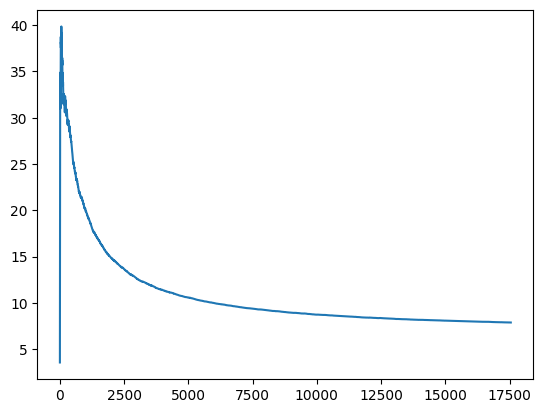

7.960848399825789


In [40]:
X,l_loss = SGD(A_train,y_train,eps=1e-8,verbose=1,batch_size=2)
print(loss(X,A_test,y_test))